Data Collection with CCXT

In [131]:
import ccxt
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Initialize the exchange
exchange = ccxt.binance()

symbol = 'BTC/USDT'
timeframe = '1d'
since = exchange.parse8601('2021-01-01T00:00:00Z')
now = exchange.milliseconds()

all_candles = []

while since < now:
    candles = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(candles) == 0:
        break
    since = candles[-1][0] + 1  # start the next fetch from the end of the last one
    all_candles += candles

# Convert to DataFrame
df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create a copy with the closing price for forecasting
data = df[['date', 'close', 'volume']].copy()
data.rename(columns={'date': 'ds', 'close': 'y', 'volume': 'volume'}, inplace=True)

print(data.head())


          ds         y         volume
0 2021-01-01  29331.69   54182.925011
1 2021-01-02  32178.33  129993.873362
2 2021-01-03  33000.05  120957.566750
3 2021-01-04  31988.71  140899.885690
4 2021-01-05  33949.53  116049.997038


Plot the historical Bitcoin prices

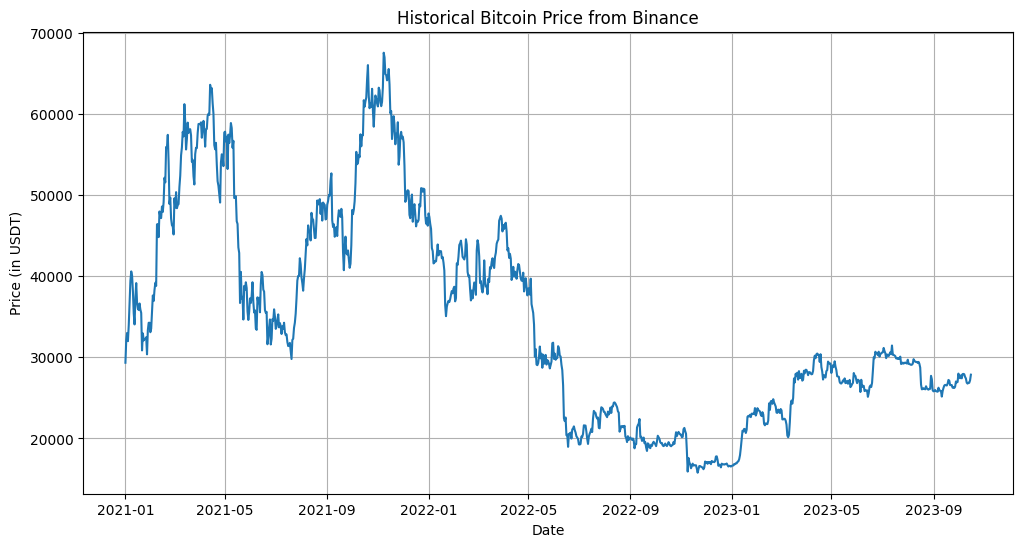

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'])
plt.title('Historical Bitcoin Price from Binance')
plt.xlabel('Date')
plt.ylabel('Price (in USDT)')
plt.grid(True)
plt.show()

Add additional regressors/features & Clean Data

In [133]:
import talib

data['rsi'] = talib.RSI(data['y'].values, timeperiod=16)
data.dropna(subset=['rsi'], inplace=True)

data['obv'] = talib.OBV(data['y'].values, data['volume'].values)
data.dropna(subset=['obv'], inplace=True)

Fit and Train the Prophet model with features/regressors

In [134]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Add RSI as a regressor
model.add_regressor('rsi')

# Add OBV as a regressor
model.add_regressor('obv')

# Train the model with the data
model.fit(data)

09:01:07 - cmdstanpy - INFO - Chain [1] start processing
09:01:07 - cmdstanpy - INFO - Chain [1] done processing


Create future date data for which we want to predict the Bitcoin prices and then generate forecasts. Also demonstrate Forecasting with the Regressor/Feature

In [135]:
# Create future dates for prediction (e.g., for the next 365 days)
future = model.make_future_dataframe(periods=365)

# Use the most recent RSI and OBV values for future predictions
last_rsi_value = data['rsi'].iloc[-1]
last_obv_value = data['obv'].iloc[-1]

future['rsi'] = last_rsi_value
future['obv'] = last_obv_value

# Generate forecasts
forecast = model.predict(future)

Visualize the predicted prices

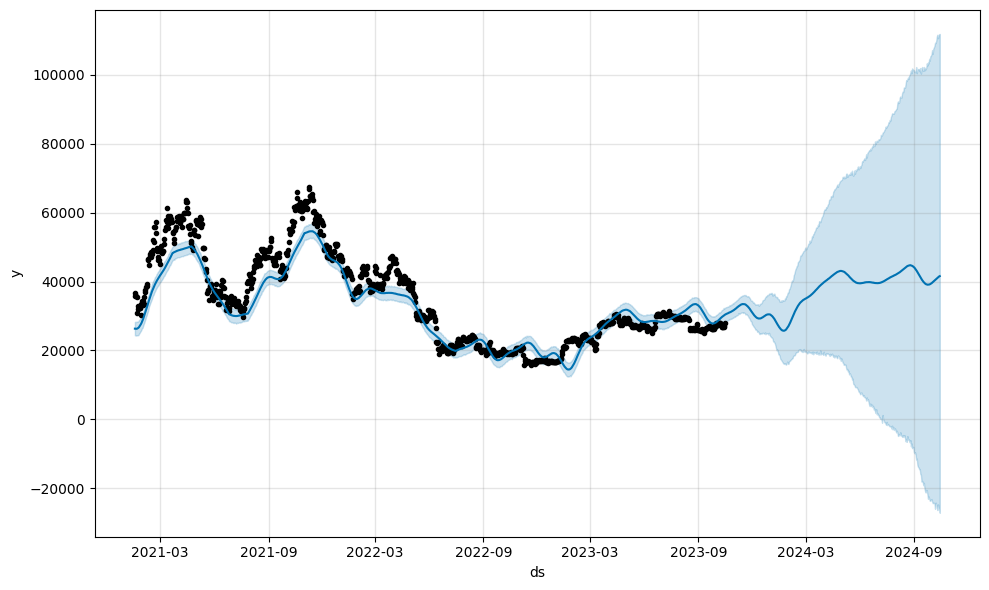

In [136]:
fig1 = model.plot(forecast)

 Break down the forecast into its various components

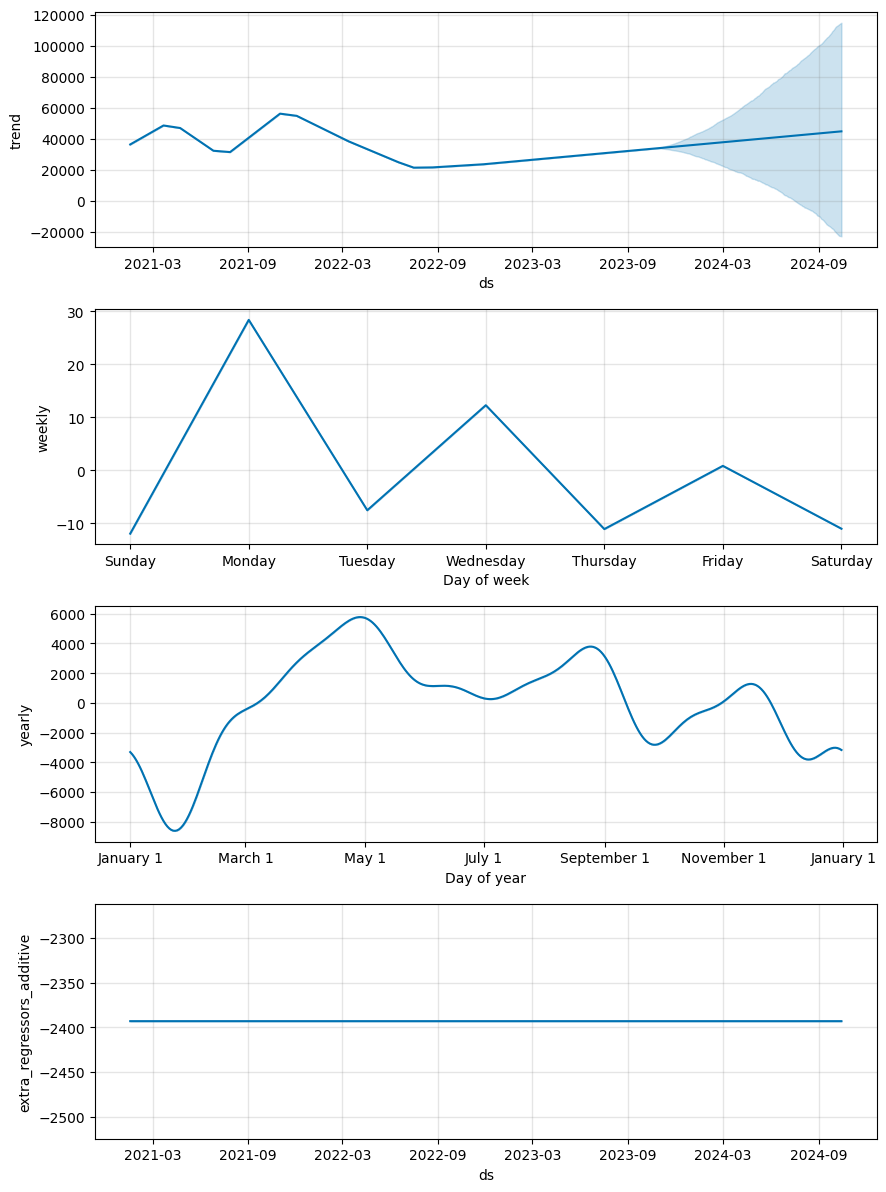

In [137]:
fig2 = model.plot_components(forecast)

Setup & Perform Cross-Validation

In [138]:
from prophet.diagnostics import cross_validation

# Here's an example setup:
# Initial training period = 730 days (2 years)
# Horizon = 90 days
# Period = 30 days (i.e., make a forecast every 30 days)

df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='90 days')


  0%|          | 0/7 [00:00<?, ?it/s]09:01:09 - cmdstanpy - INFO - Chain [1] start processing
09:01:09 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:02,  2.49it/s]09:01:09 - cmdstanpy - INFO - Chain [1] start processing
09:01:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:01,  2.72it/s]09:01:09 - cmdstanpy - INFO - Chain [1] start processing
09:01:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:01,  2.44it/s]09:01:10 - cmdstanpy - INFO - Chain [1] start processing
09:01:10 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:01<00:01,  2.48it/s]09:01:10 - cmdstanpy - INFO - Chain [1] start processing
09:01:10 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:00,  2.42it/s]09:01:11 - cmdstanpy - INFO - Chain [1] start processing
09:01:11 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:02<00:00,  2.09it/s]09:01:11 - cmds

Compute Performance Metrics

In [139]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon           mse         rmse          mae      mape     mdape  \
0  9 days  7.527996e+06  2743.719439  2218.102740  0.084675  0.057877   
1 10 days  8.124031e+06  2850.268614  2312.994626  0.088412  0.057877   
2 11 days  9.418195e+06  3068.907811  2427.069146  0.093100  0.058760   
3 12 days  1.097433e+07  3312.752583  2583.074601  0.099481  0.058760   
4 13 days  1.265979e+07  3558.059869  2774.261416  0.107166  0.069757   

      smape  coverage  
0  0.090112  0.571429  
1  0.094454  0.571429  
2  0.100697  0.571429  
3  0.108756  0.571429  
4  0.118086  0.539683  


Visualizing Performance

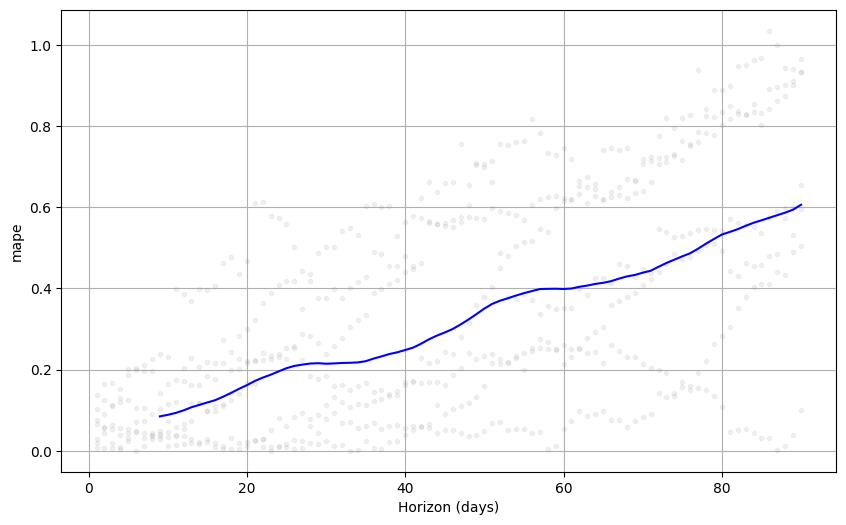

In [140]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

Compute the percentage accuracy from MAPE

In [141]:
# Assuming df_p is the result from the performance_metrics function
mape = df_p['mape'].mean()
accuracy = 100 - (mape * 100)
print(f"Forecast Accuracy: {accuracy:.2f}%")

Forecast Accuracy: 66.71%
